In [6]:
import os, cv2
import matplotlib.pyplot as plt
import zipfile, gdown
import kagglehub
import shutil
import numpy as np

In [7]:
# skip this cell if dataset is already downloaded
if os.path.exists("../data/brain_tumor_dataset"):

    print("Dataset already exists. Skipping download.")

else:

    # Download latest version to kaggle cache
    path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

    print("Path to dataset files:", path)

    # Create data directory if it doesn't exist
    data_dir = "../data/"
    os.makedirs(data_dir, exist_ok=True)

    # Copy the downloaded dataset to data directory
    destination = os.path.join(data_dir, "brain_tumor_dataset")
    if os.path.exists(destination):
        shutil.rmtree(destination)  # Remove if already exists
    shutil.copytree(path, destination)

    print(f"Dataset copied to: {destination}")

Dataset already exists. Skipping download.


We'll start by printing a list of the folders and files in the dataset to get an idea of its structure.

In [8]:
# Explore the downloaded dataset structure
dataset_path = "../data/brain_tumor_dataset"
print("Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

Dataset structure:
brain_tumor_dataset/
  Training/
    no_tumor/
      image(115).jpg
      image(142).jpg
      image(49).jpg
      image(1).jpg
      image(284).jpg
      ... and 390 more files
    meningioma_tumor/
      m1(69).jpg
      m3 (126).jpg
      m3 (62).jpg
      m2 (62).jpg
      m1(86).jpg
      ... and 817 more files
    glioma_tumor/
      gg (362).jpg
      gg (698).jpg
      gg (732).jpg
      gg (227).jpg
      gg (677).jpg
      ... and 821 more files
    pituitary_tumor/
      p (477).jpg
      p (162).jpg
      p (498).jpg
      p (532).jpg
      p (75).jpg
      ... and 822 more files
  Testing/
    no_tumor/
      image(49).jpg
      image(1).jpg
      image(103).jpg
      image(73).jpg
      image(24).jpg
      ... and 100 more files
    meningioma_tumor/
      image(49).jpg
      image(1).jpg
      image(73).jpg
      image(24).jpg
      image(32).jpg
      ... and 110 more files
    glioma_tumor/
      image(49).jpg
      image(1).jpg
      image(73).jpg
 

This shows that our data is split between training and testing already. Within each category, there is a 'no_tumor' folder that contains images of healthy brains, and three other foldrs that contain images of brains with tumors, broken down by type of tumor. Let's take a peak at a couple of examples from each category in the training dataset to see if we can see the differences by eye.

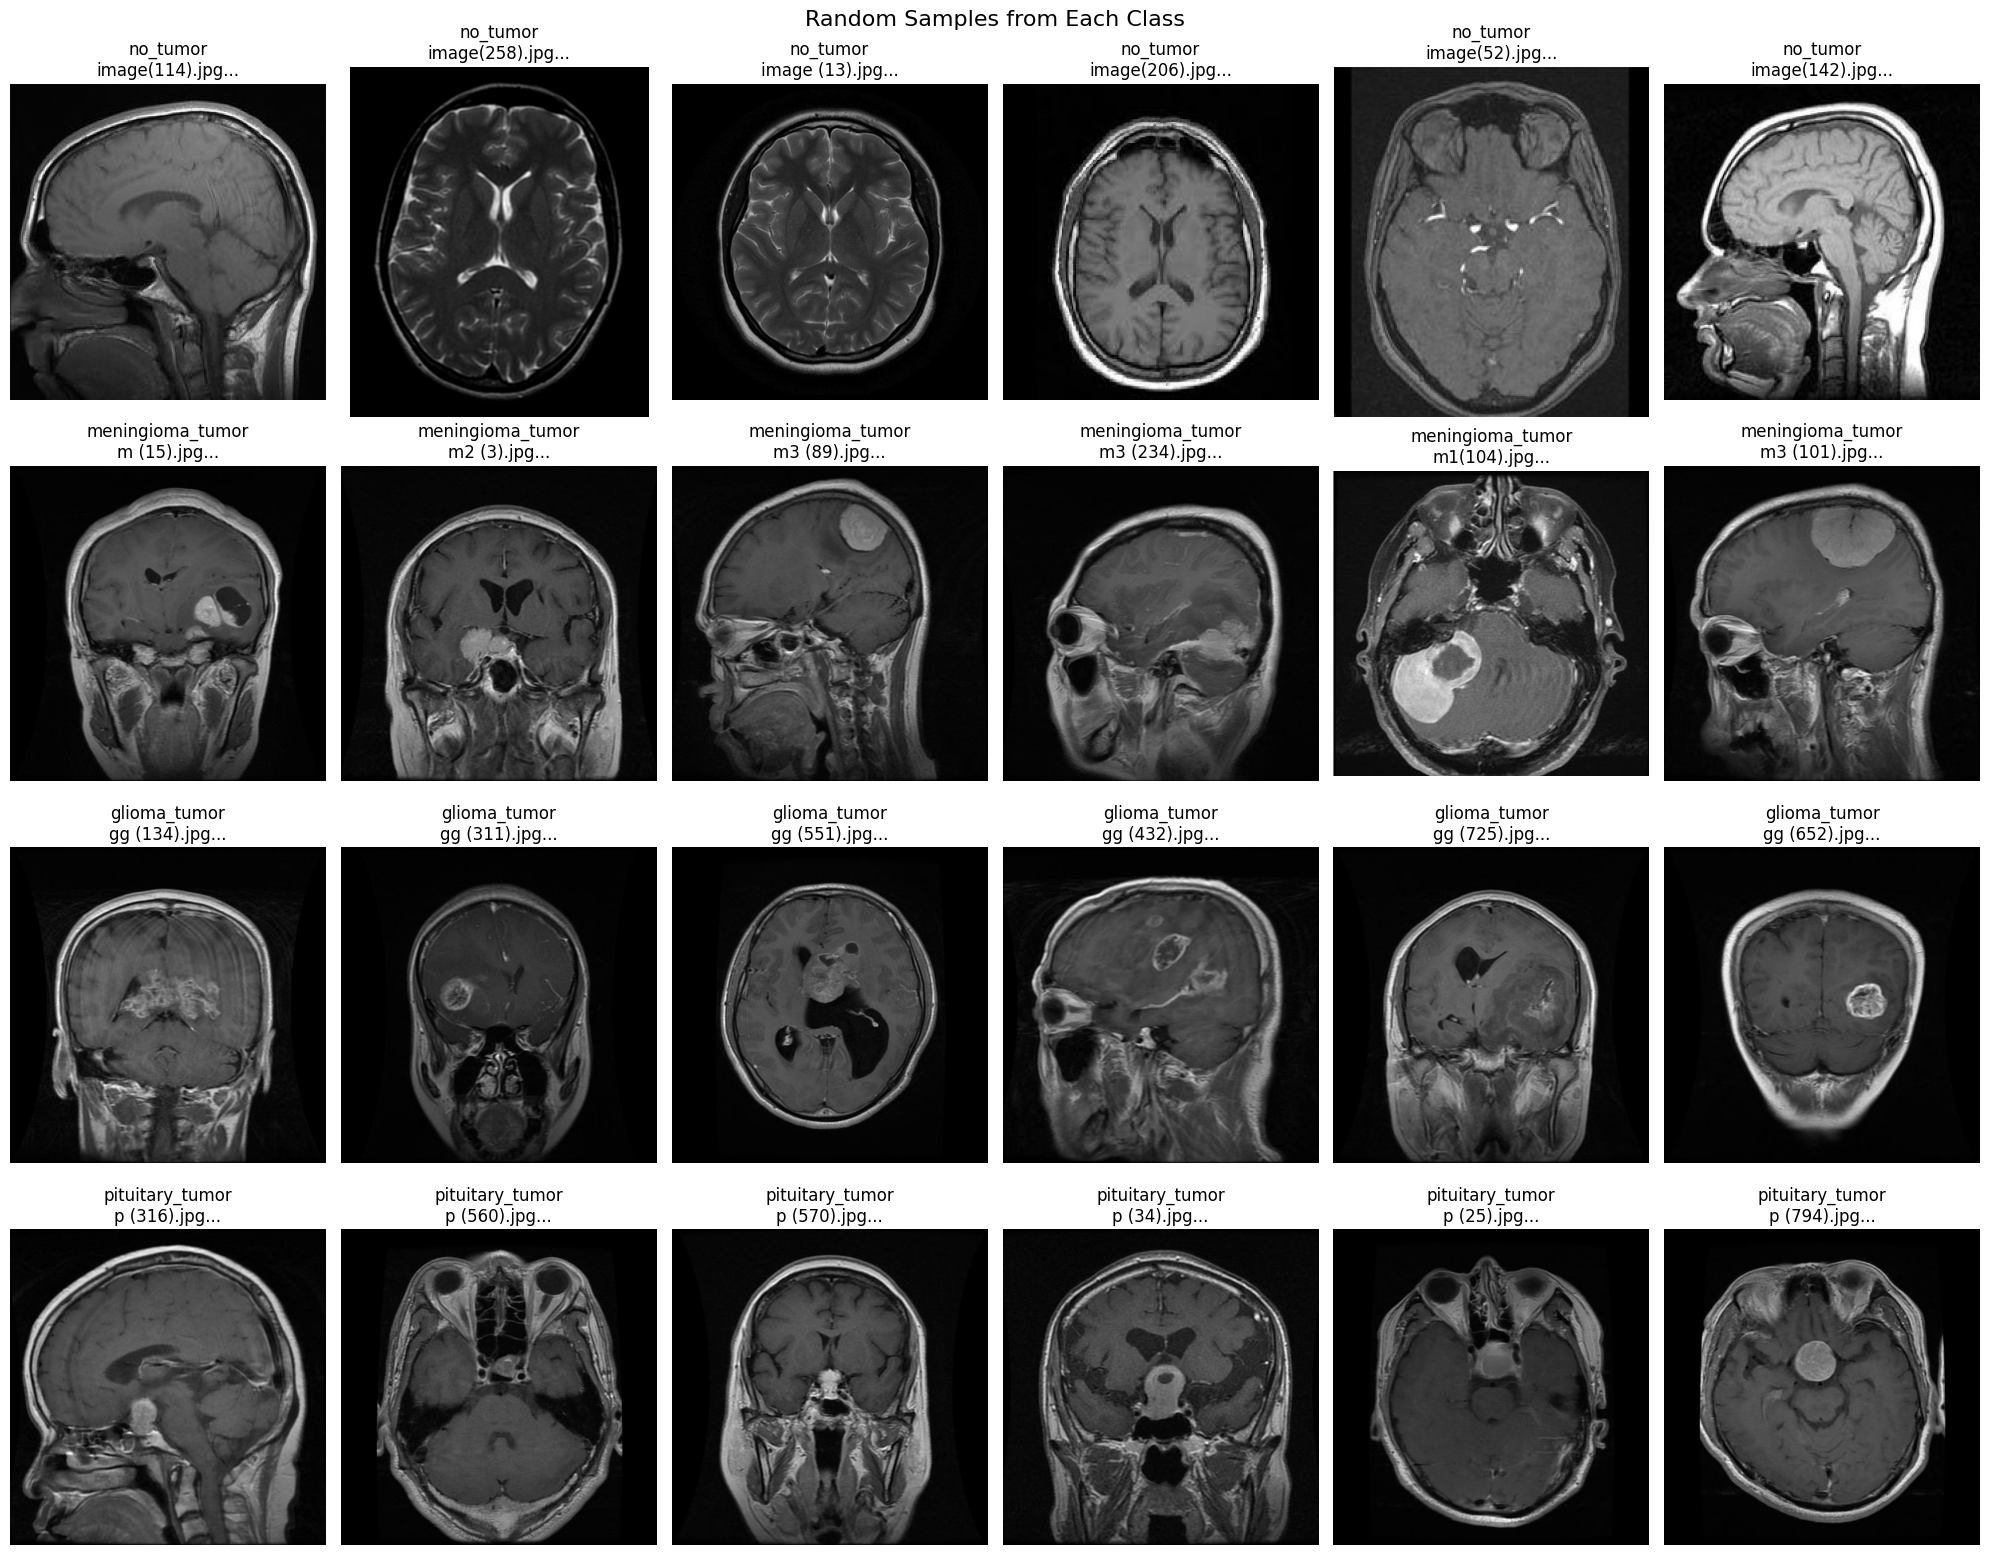

In [9]:
# Get list of classes
classes = os.listdir(os.path.join(dataset_path, "Training"))

# Random Sample Grid Visualization
def show_random_samples(samples_per_class=6):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(20, 4 * len(classes)))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Randomly sample images
        random_images = np.random.choice(images, min(samples_per_class, len(images)), replace=False)
        
        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{cls}\n{img_name[:20]}...")
                axes[i, j].axis('off')
    
    plt.suptitle('Random Samples from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

show_random_samples()

As fascinating as I find the brain, I am far from being an expert on it. The differences between no tumor and meningioma tumor are bleak.  The same is true for glioma. Personally, I am not sure I can point out tumors in the pituitary gland. Nonetheless, I think it's useful to just look up a quick labeled picture of the different parts of the brain. Also, it's interesting to note that the angle of the images varies--some are aerial MRI images, while others are taking from the front/back/sides.

![Alt text](https://files.miamineurosciencecenter.com/media/filer_public_thumbnails/filer_public/f1/f7/f1f7a2b1-1599-44c7-84a4-54510a6bf308/brain_tumor_locations.jpg__800x494_q85_subject_location-578%2C484_subsampling-2.jpg "")

With a basic understanding of the dataset structure and its contents, I want to find out more about its stats--how many images it has, what the balance is between the different classes, what the images sizes are, etc. It looks like we have monochrome images but not all images are exactly the same size. 

Dataset Statistics:
Dataset           Testing  Training
Class                              
glioma_tumor          100       826
meningioma_tumor      115       822
no_tumor              105       395
pituitary_tumor        74       827


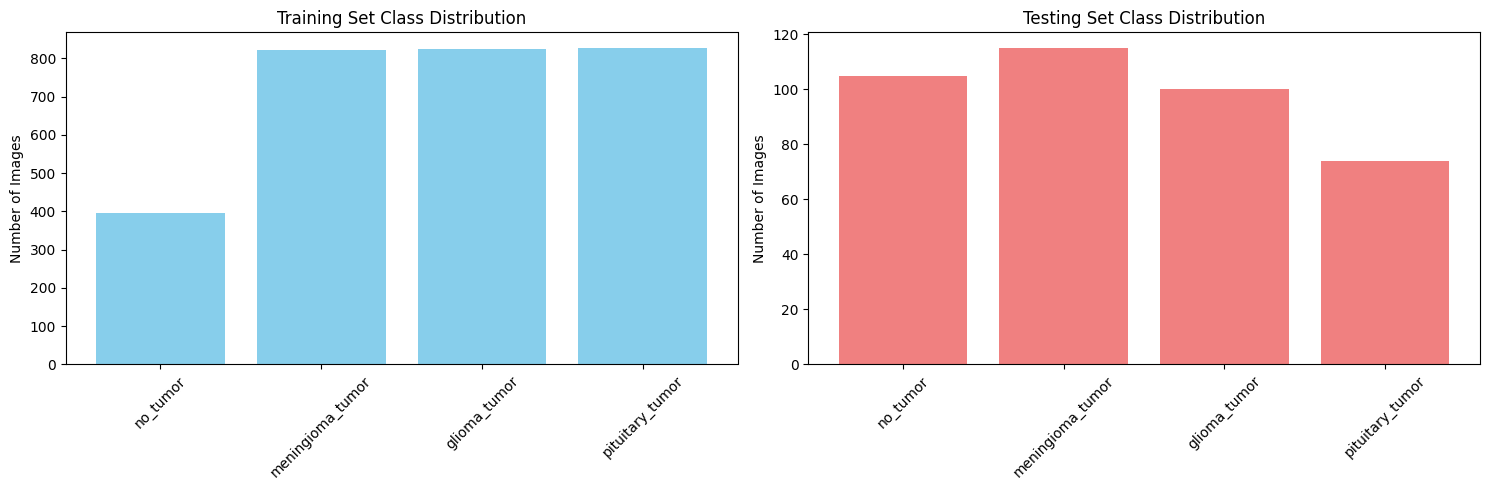

In [10]:
# 1. Dataset Statistics and Class Distribution
import numpy as np
import pandas as pd
from collections import Counter

# Collect dataset statistics
stats = []
for dataset_type in ["Training", "Testing"]:
    dataset_path = os.path.join("../data/brain_tumor_dataset", dataset_type)
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        stats.append({'Dataset': dataset_type, 'Class': cls, 'Count': num_images})

df_stats = pd.DataFrame(stats) # Create DataFrame from stats
print("Dataset Statistics:")
print(df_stats.pivot(index='Class', columns='Dataset', values='Count'))

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
train_counts = df_stats[df_stats['Dataset'] == 'Training']
ax1.bar(train_counts['Class'], train_counts['Count'], color='skyblue')
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Testing set distribution
test_counts = df_stats[df_stats['Dataset'] == 'Testing']
ax2.bar(test_counts['Class'], test_counts['Count'], color='lightcoral')
ax2.set_title('Testing Set Class Distribution')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The test dataset is roughly evenly distributed (the pituitary class could use a few more samples for better balance) while the test dataset has fewer examples of the healthy MRIs. My initial thoughts on this are that this kind of balance is not the worst in a tumor classification dataset--false positives are worse than false negatives. In other words, I care more that my model can recognize tumored brains better than healthy brains, since missing a diagnosis can be detrimental. I'd be more concerned if we had a lot of healthy brain images, and a small subset of tumored brains.

Image Dimension Statistics:
Height - Min: 200, Max: 1322, Mean: 435.4
Width - Min: 200, Max: 1358, Mean: 434.3
Channels - Min: 3, Max: 3, Mean: 3.0
Unique dimensions: 39


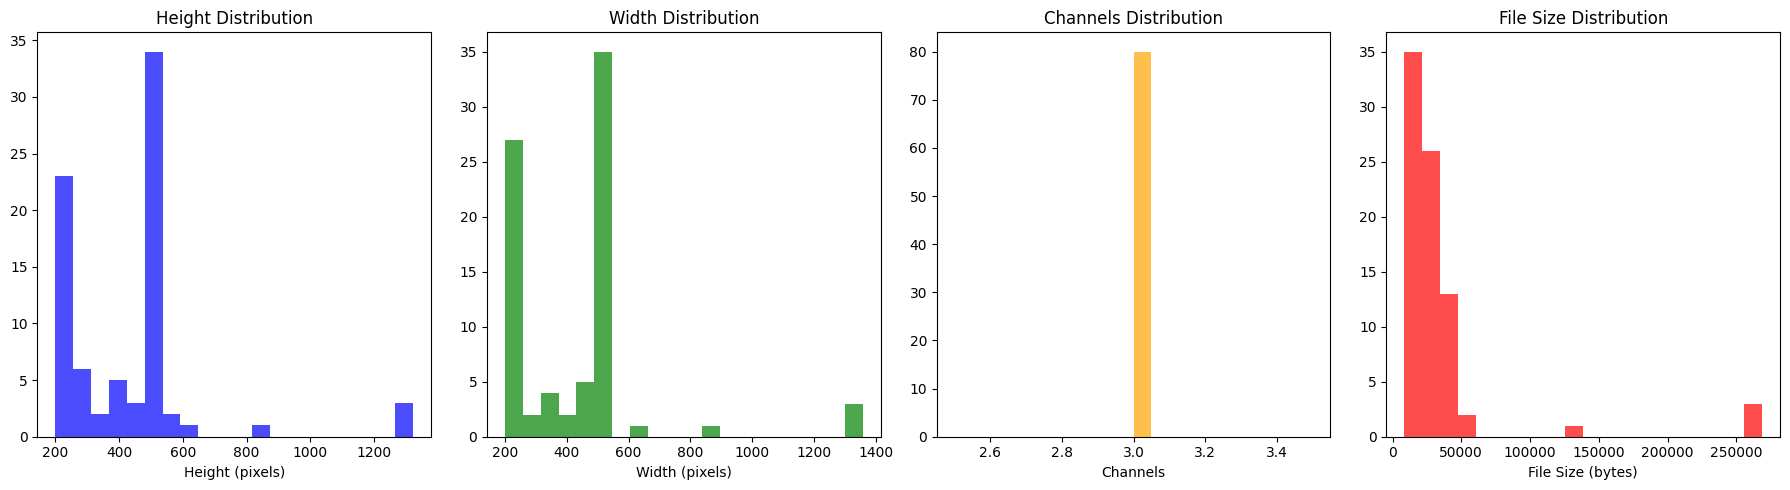

In [11]:
# Image Size Analysis
def analyze_image_dimensions():
    """Analyze and visualize image dimensions in the dataset.
    Inputs:         None (uses predefined dataset path)
    Outputs:        DataFrame with image dimensions statistics (Height, Width, Channels)
    """
    dimensions = []
    file_sizes = []
    
    for dataset_type in ["Training", "Testing"]:
        dataset_path = os.path.join("../data/brain_tumor_dataset", dataset_type)
        for cls in classes:
            class_dir = os.path.join(dataset_path, cls)
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Sample 10 images per class to avoid loading too many
            sample_images = images[:10] if len(images) > 10 else images
            
            for img_name in sample_images:
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    h, w, c = img.shape # height, width, channels
                    dimensions.append({'Dataset': dataset_type, 'Class': cls, 'Height': h, 'Width': w, 'Channels': c})
                    file_sizes.append(os.path.getsize(img_path))
    
    df_dims = pd.DataFrame(dimensions)
    
    print("Image Dimension Statistics:")
    print(f"Height - Min: {df_dims['Height'].min()}, Max: {df_dims['Height'].max()}, Mean: {df_dims['Height'].mean():.1f}")
    print(f"Width - Min: {df_dims['Width'].min()}, Max: {df_dims['Width'].max()}, Mean: {df_dims['Width'].mean():.1f}")
    print(f"Channels - Min: {df_dims['Channels'].min()}, Max: {df_dims['Channels'].max()}, Mean: {df_dims['Channels'].mean():.1f}")
    print(f"Unique dimensions: {df_dims[['Height', 'Width']].drop_duplicates().shape[0]}")
    
    # Plot dimension distribution
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    axes[0].hist(df_dims['Height'], bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Height Distribution')
    axes[0].set_xlabel('Height (pixels)')
    
    axes[1].hist(df_dims['Width'], bins=20, alpha=0.7, color='green')
    axes[1].set_title('Width Distribution')
    axes[1].set_xlabel('Width (pixels)')

    axes[2].hist(df_dims['Channels'], bins=20, alpha=0.7, color='orange')
    axes[2].set_title('Channels Distribution')
    axes[2].set_xlabel('Channels')
    
    axes[3].hist(file_sizes, bins=20, alpha=0.7, color='red')
    axes[3].set_title('File Size Distribution')
    axes[3].set_xlabel('File Size (bytes)')
    
    plt.tight_layout()
    plt.show()
    
    return df_dims

df_dimensions = analyze_image_dimensions()

Above is an analysis of the image sizes. There are a small number of images that are quite large--making out to 1200x1200+ pixels, but most are in the ballpark ~500x500. The channels distribution here caught me off guard. Since the images are black and white, I naively expected them to have only one channel (monochrome) whereas 3 channels are typically used for RGB (colored) images. Let's investigate if there are differences between the three channels.

In [12]:
# Check if the channels are identical (pseudo-grayscale)

def check_grascale_channels():
    # generate a list of sample images from each class
    sample_images = []
    for cls in classes:
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [file for file in os.listdir(class_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sample_images.extend([os.path.join(class_dir, img) for img in images[:100]])  # take first few images from each class

    for img_path in sample_images:
        img = cv2.imread(img_path)

        if img is not None and img.shape[2] == 3:  # ensure image has 3 channels

            # separate the channels into arrays
            channel_1 = img[:, :, 0]
            channel_2 = img[:, :, 1]
            channel_3 = img[:, :, 2]
            
            # compare the channel arrays
            if np.array_equal(channel_1, channel_2) and np.array_equal(channel_1, channel_3):
                pass
                #print(f"Image {os.path.basename(img_path)} has identical channels (grayscale).")
            else:
                print(f"Image {os.path.basename(img_path)} has different channels (not grayscale).")
        else:
            print(f"Image {os.path.basename(img_path)} could not be processed.")

check_grascale_channels()


The code above goes through a a list of 100 images from each class and prints a message if the channels are not identical. Since there is no output, this indicates all images that were processed had identical channels.

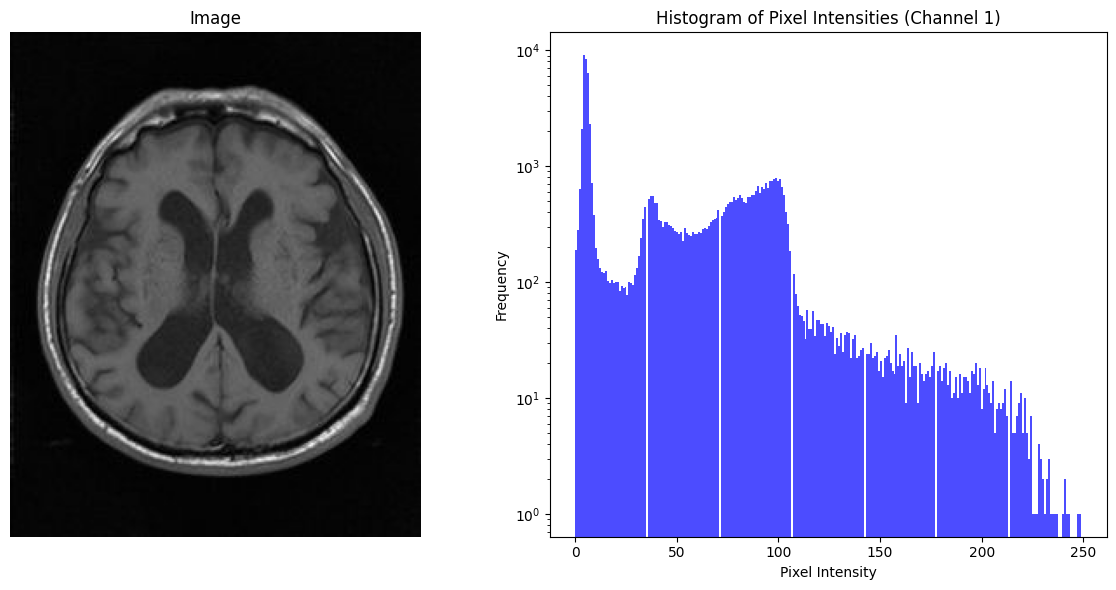

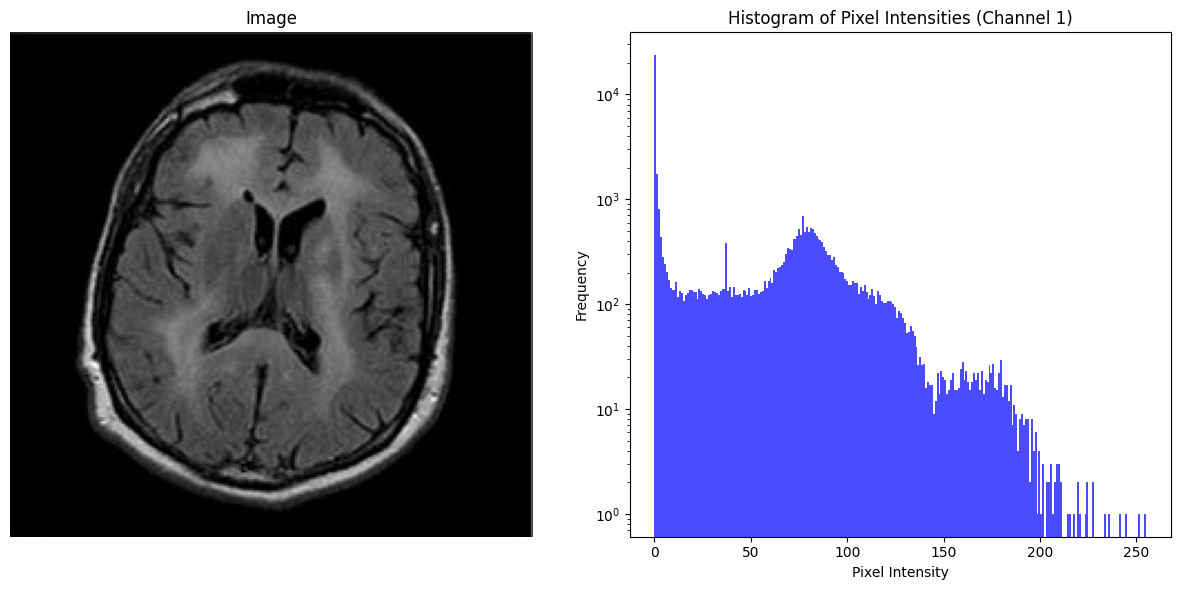

In [20]:
# Plot an image, and next to it plot a histogram of pixel intensities in the first channel

def plot_image_and_histogram(img_path):
    
    # split figure into two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot image in first subplot
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(img)
    ax1.set_title("Image")
    ax1.axis('off')

    # get first channel
    channel_1 = img[:, :, 0]

    # plot histogram of pixel intensities in second subplot
    ax2.hist(channel_1.ravel(), bins=256, color='blue', alpha=0.7)
    ax2.set_title("Histogram of Pixel Intensities (Channel 1)")
    ax2.set_xlabel("Pixel Intensity")
    ax2.set_ylabel("Frequency")
    plt.tight_layout()
    # set y axis to log scale
    ax2.set_yscale('log')


plot_image_and_histogram(os.path.join("../data/brain_tumor_dataset/Training/no_tumor/image(1).jpg"))
plot_image_and_histogram(os.path.join("../data/brain_tumor_dataset/Training/no_tumor/image(2).jpg"))

The histogram for image one shows sighs of discretization. I was curious if this was true for all images, so I just repeated the same analysis for image 2, which is not discretized. I suppose this could be a result of some processing step that was applied to a subset of the data. This seems feasible considering these images are likely amassed from different hospitals and hence are produced and processed with different hardware/software/etc.

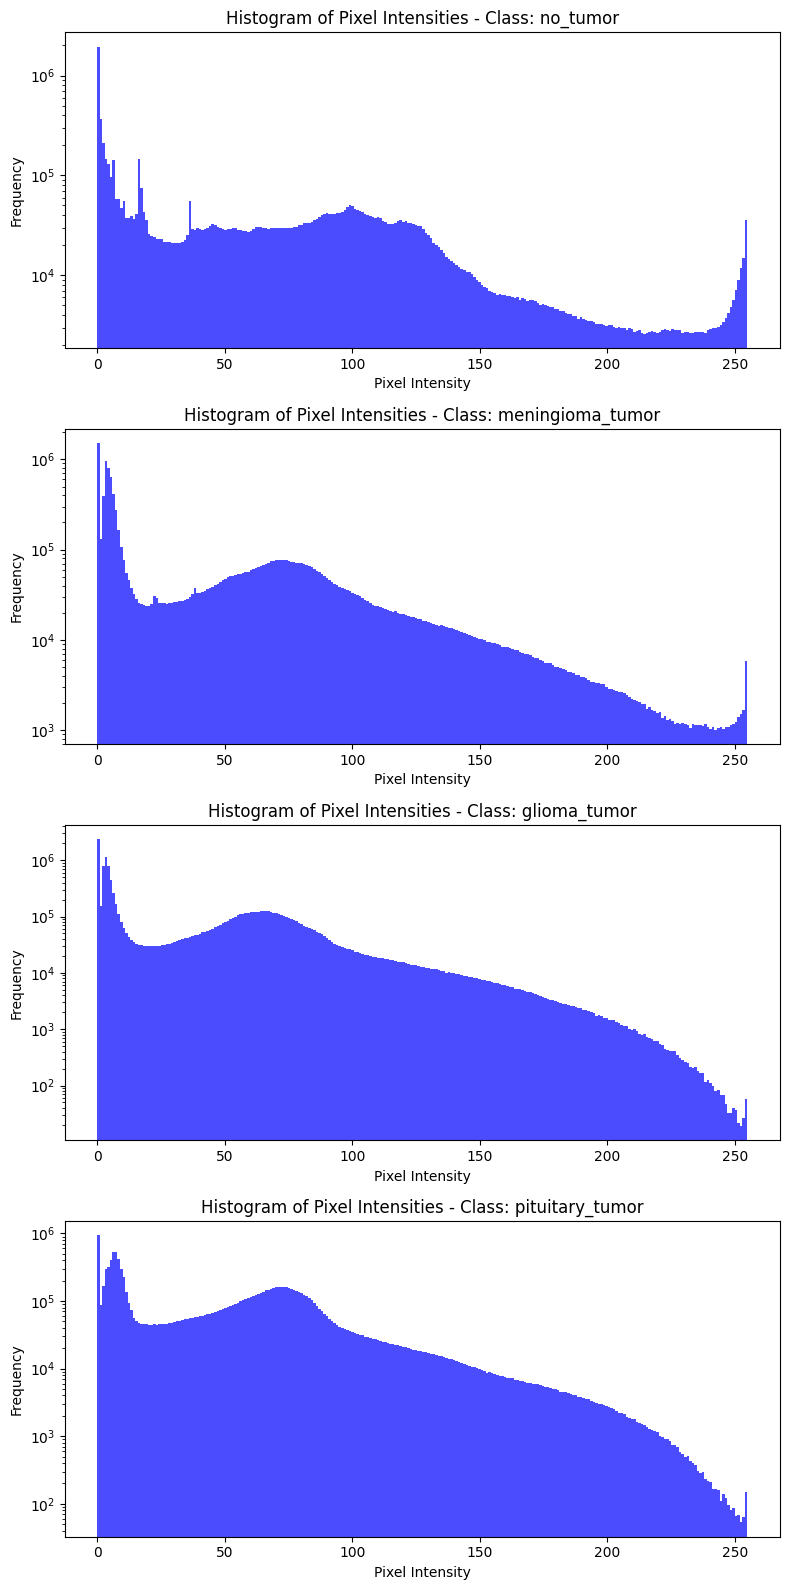

In [24]:
# Plot pixel intensity histogram for each class
def plot_histograms_per_class():
    fig, axes = plt.subplots(len(classes), 1, figsize=(8, 4 * len(classes)))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample 50 images per class to avoid overloading
        sample_images = images[:50] if len(images) > 50 else images
        
        all_channel_1 = []
        
        for img_name in sample_images:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                channel_1 = img[:, :, 0]
                all_channel_1.extend(channel_1.ravel())
        
        axes[i].hist(all_channel_1, bins=256, color='blue', alpha=0.7)
        axes[i].set_title(f"Histogram of Pixel Intensities - Class: {cls}")
        axes[i].set_xlabel("Pixel Intensity")
        axes[i].set_ylabel("Frequency")
        axes[i].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_histograms_per_class()

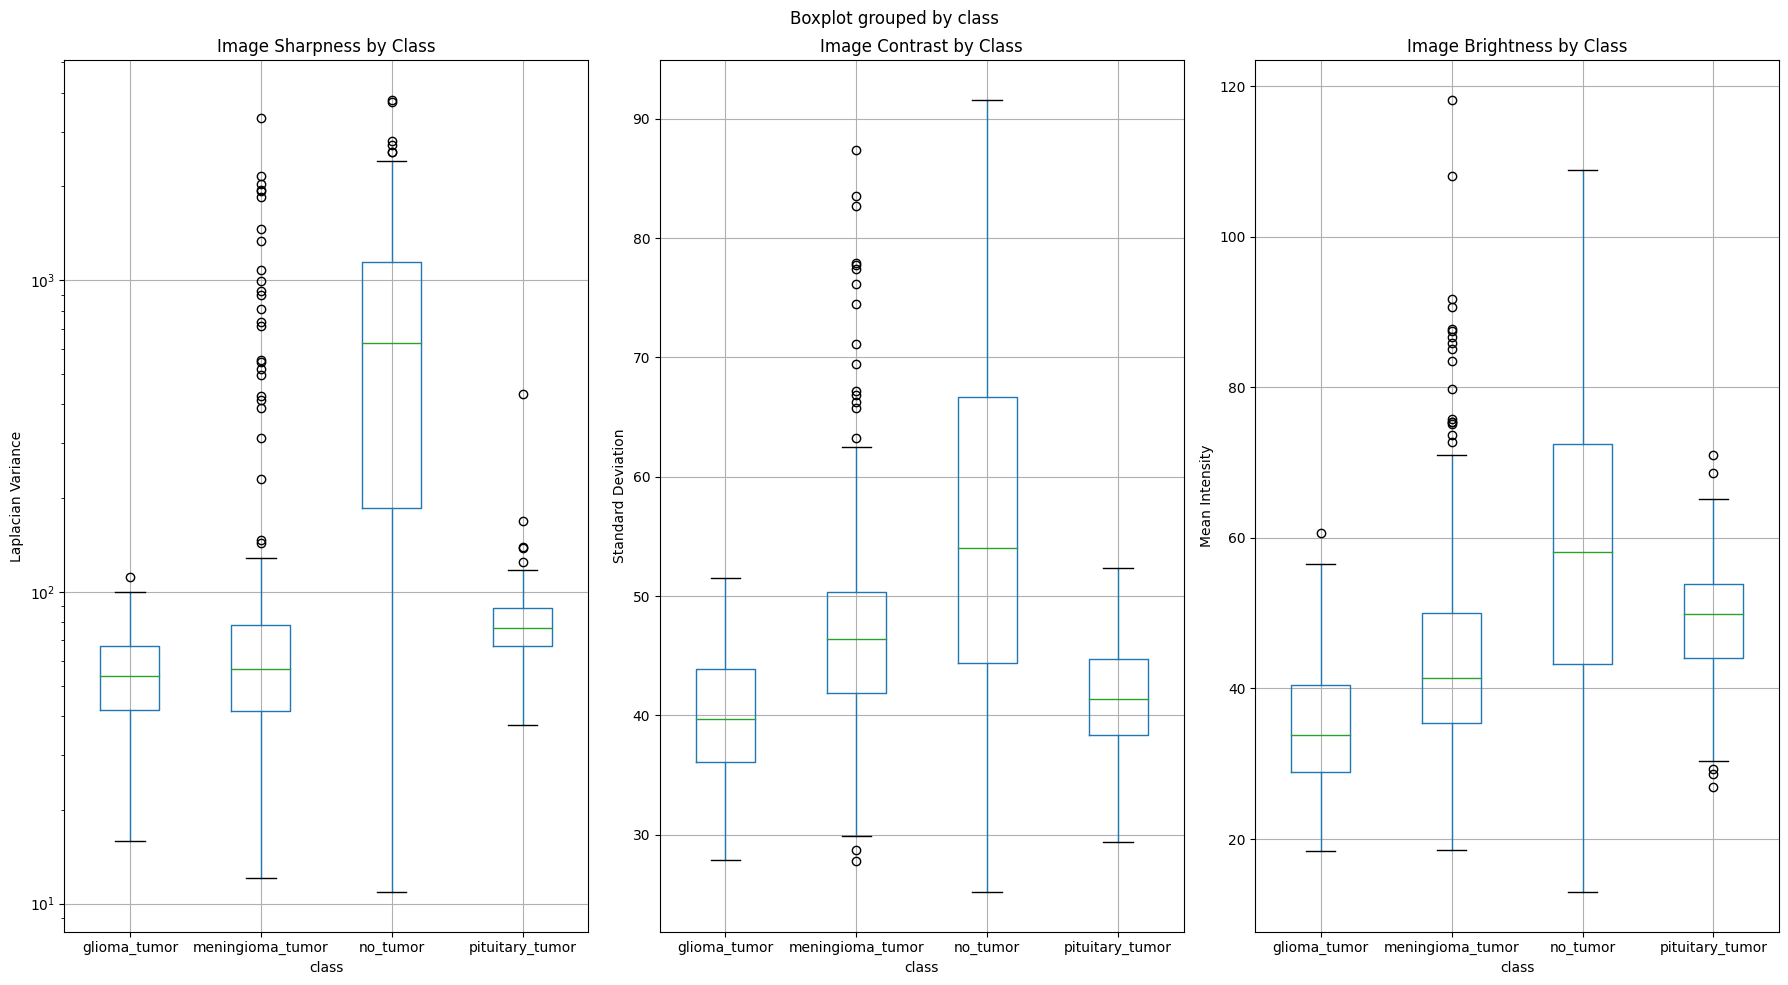

In [22]:
# Image Quality Assessment
def assess_image_quality():
    quality_metrics = []
    
    for cls in classes:
        class_dir = os.path.join("../data/brain_tumor_dataset/Training", cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample 15 images per class
        sample_images = images[:200] if len(images) > 200 else images
        
        for img_name in sample_images:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Calculate Laplacian variance (focus measure)
                laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
                
                # Calculate contrast (std of pixel intensities)
                contrast = np.std(img)
                
                # Calculate brightness (mean of pixel intensities)
                brightness = np.mean(img)
                
                quality_metrics.append({
                    'class': cls,
                    'image': img_name,
                    'sharpness': laplacian_var,
                    'contrast': contrast,
                    'brightness': brightness
                })
    
    df_quality = pd.DataFrame(quality_metrics)
    
    # Plot quality metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 10))
    
    df_quality.boxplot(column='sharpness', by='class', ax=axes[0])
    axes[0].set_title('Image Sharpness by Class')
    axes[0].set_ylabel('Laplacian Variance')
    axes[0].set_yscale('log')
    
    df_quality.boxplot(column='contrast', by='class', ax=axes[1])
    axes[1].set_title('Image Contrast by Class')
    axes[1].set_ylabel('Standard Deviation')
    
    df_quality.boxplot(column='brightness', by='class', ax=axes[2])
    axes[2].set_title('Image Brightness by Class')
    axes[2].set_ylabel('Mean Intensity')
    
    plt.tight_layout()
    plt.show()
    
    return df_quality

df_quality = assess_image_quality()

## Image Quality Analysis

The above code studies image quality through three metrics: Laplacian variance, standard deviation, and mean intensity. Each metric is described in more detail as follows.

#### Laplacian Variance

[This](https://medium.com/@sagardhungel/laplacian-and-its-use-in-blur-detection-fbac689f0f88) article gives a nice, intuitive understanding of how the Laplacian Variance is calculated. In the simplest of explanations, it basically looks for areas of rapid changes in the image--e.g. edges. If an image is blurry, it has softer edges, and would have a lower Laplacian Variance score. Based on the graph above, we see that the healthy brain category contains the sharpest images. 

#### Standard Deviation

Pixel brightness occurs on a scale between 0 - 255. The second graph shows a distribution of the standard deviation of brightnesses per image. Again, the healthy brain category has the highest standard deviation. This corresponds to a higher contrast. Images with lower contrast have pixel intensities that are more closely distributed. 

#### Mean Intensity

The third graph shows mean intensity, which means it's a measure of brightness. Unsurprisingly, the healthy brain category is again at the top here. 

In [ ]:
# Summary Statistics
print("=== DATASET SUMMARY ===")
print(f"Total classes: {len(classes)}")
print(f"Class names: {classes}")

total_train = df_stats[df_stats['Dataset'] == 'Training']['Count'].sum()
total_test = df_stats[df_stats['Dataset'] == 'Testing']['Count'].sum()
print(f"Total training images: {total_train}")
print(f"Total testing images: {total_test}")
print(f"Total images: {total_train + total_test}")

print("\n=== CLASS BALANCE ===")
train_balance = df_stats[df_stats['Dataset'] == 'Training']
for _, row in train_balance.iterrows():
    percentage = (row['Count'] / total_train) * 100
    print(f"{row['Class']}: {row['Count']} images ({percentage:.1f}%)")

print(f"\n=== IMAGE PROPERTIES ===")
if 'df_dimensions' in locals():
    print(f"Common image size: {df_dimensions['Height'].mode().iloc[0]}x{df_dimensions['Width'].mode().iloc[0]}")
    print(f"Size variation: Height ({df_dimensions['Height'].min()}-{df_dimensions['Height'].max()}), Width ({df_dimensions['Width'].min()}-{df_dimensions['Width'].max()})")

if 'df_quality' in locals().keys():
    print(f"\n=== QUALITY METRICS ===")
    print(f"Average sharpness: {df_quality['sharpness'].mean():.2f}")
    print(f"Average contrast: {df_quality['contrast'].mean():.2f}")
    print(f"Average brightness: {df_quality['brightness'].mean():.2f}")

=== DATASET SUMMARY ===
Total classes: 4
Class names: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
Total training images: 2870
Total testing images: 394
Total images: 3264

=== CLASS BALANCE ===
no_tumor: 395 images (13.8%)
meningioma_tumor: 822 images (28.6%)
glioma_tumor: 826 images (28.8%)
pituitary_tumor: 827 images (28.8%)
__name__
__doc__
__package__
__loader__
__spec__
__builtin__
__builtins__
_ih
_oh
_dh
In
Out
get_ipython
exit
quit
open
_
__
___
__vsc_ipynb_file__
_i
_ii
_iii
_i1
os
cv2
plt
zipfile
gdown
kagglehub
shutil
_i2
_i3
dataset_path
root
dirs
files
level
indent
subindent
file
_i4
training_path
classes
fig
axes
i
cls
class_dir
images
j
img_path
img
_i5
dataset_type
num_images
_i6
_i7
_i8
_i9
np
_i10
pd
Counter
stats
df_stats
ax1
ax2
train_counts
test_counts
_i11
analyze_image_dimensions
df_dimensions
_i12
total_train
total_test
train_balance
row
percentage
_i13
_i14
_i15
_i16
_i17
each
_i18
_i19
_i20

=== IMAGE PROPERTIES ===
Common image size: 5